Install dependencies

In [1]:
!find . | grep -E "(__pycache__|\.pyc|\.pyo$)" | xargs rm -rf

In [2]:
pip install --force-reinstall neo4j langchain-openai langchain langchain-community langchain-huggingface pandas tabulate pydub ffprobe-python feedparser elevenlabs tavily-python

  Using cached neo4j-5.28.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached langchain_openai-0.3.9-py3-none-any.whl.metadata (2.3 kB)
  Using cached langchain-0.3.20-py3-none-any.whl.metadata (7.7 kB)
  Using cached langchain_community-0.3.19-py3-none-any.whl.metadata (2.4 kB)
  Using cached langchain_huggingface-0.1.2-py3-none-any.whl.metadata (1.3 kB)
  Using cached pandas-2.2.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached ffprobe_python-1.0.3-py3-none-any.whl.metadata (2.6 kB)
  Using cached feedparser-6.0.11-py3-none-any.whl.metadata (2.4 kB)
  Using cached elevenlabs-1.54.0-py3-none-any.whl.metadata (7.3 kB)
  Using cached tavily_python-0.5.1-py3-none-any.whl.metadata (91 kB)
  Using cached pytz-2025.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached langchain_core-0.3.45-py3-none-any.whl.metadata (5.9 kB)
  Using cached open

Setup env vars

In [3]:
import os

# Set up Our instance of Chatgpt and neo4J
os.environ['AZURE_OPENAI_API_KEY'] = "********"
os.environ['AZURE_OPENAI_API_VERSION'] = "******"
os.environ['AZURE_OPENAI_DEPLOYMENT'] = "*****"
os.environ['AZURE_OPENAI_ENDPOINT'] = "******"
os.environ['AZURE_OPENAI_VERSION'] = "*****"


Creation of the graph

In [4]:
import os
from typing import Annotated
from langchain_openai import AzureChatOpenAI
from pydantic import BaseModel, Field
from langgraph.graph import END, START, StateGraph, MessagesState
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from typing import Literal
import json


llm_model = AzureChatOpenAI(
            azure_deployment=os.environ.get("AZURE_OPENAI_DEPLOYMENT"),
            model_version=os.environ.get("AZURE_OPENAI_VERSION"),
            api_version=os.environ.get("AZURE_OPENAI_API_VERSION"),
        )


In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    loop_needed: bool
    content: str
    updated_content : str


class Reflect(BaseModel):
    """Verify if the correct answer is correct given a json with the question, correct answer and incorrect answers. 
    Keep always Spanish as the input and output language. 
    If it is not, return True. If it is correct, return False in the field loop_needed.
    The output field should contain a new version of the JSON with the correct answer fixed. 
    JSON Schema:
    {
        "type": "object",
        "properties": {
            "question": {
                "type": "string",
                "description": "The trivia question"
            },
            "correctAnswer": {
                "type": "string",
                "description": "The correct answer"
            },
            "incorrectAnswers": {
                "type": "array",
                "items": {
                    "type": "string"
                },
                "description": "List of incorrect answers"
            }
        },
        "required": [
            "question",
            "correctAnswer",
            "incorrectAnswers"
        ]
    }
    """
    
    loop_needed : bool = Field(description="True if the correct answer is not correct")
    output : str = Field(description="The json with the format")
    reason : str = Field(description="Explain why the answer is correct or not")

is_a_loop_needed = llm_model.with_structured_output(
            Reflect
        )

def reflect_context(state: State):
        if(state.get("loop_needed", False) or False):
            return {
                "loop_needed": False,
                "updated_content" : state.get("updated_content","")
            }  
        else:
            result = is_a_loop_needed.invoke(state["content"])
            print(result.loop_needed)
            print(result.reason)
            print(result.output)
            return {
                "loop_needed": result.loop_needed,
                "updated_content" : result.output
            }

def reflect_conditional_context(state: State) -> Literal["generate_question", END]:
        if state.get("loop_needed", False):
            return "generate_question"
        else:
            return END

In [12]:

#model to format the reponse

class GenerateQuestion(BaseModel):
    """You are a trivia expert generating questions for a trivia game. Generate a structured response based on the given category. 
    The category is coming in Spanish. 
    The output field should contain a new version of the JSON with the correct answer fixed. 
    Keep Spanish as the output language.
    When the category is "cine y tv", the question should be about a movie or a tv show.
    When the category is "geografía", the question should be about a country, a city or a landmark.
    When the category is "historia", the question should be about a historical event, a person or a place.
    When the category is "deportes", the question should be about a sport, a player or a team.
    When the category is "corazón", the question should be about a romantic relationship, a break-up or a love story of famous people.
    When the category is "videojuegos", the question should be about a video game, a character or a game console.
    When the category is "tongurso", one of the incorrect answers should be a typo of the correct answer and you can pick a random category.
    JSON Schema:
    {
        "type": "object",
        "properties": {
            "question": {
                "type": "string",
                "description": "The trivia question"
            },
            "correctAnswer": {
                "type": "string",
                "description": "The correct answer"
            },
            "incorrectAnswers": {
                "type": "array",
                "items": {
                    "type": "string"
                },
                "description": "List of incorrect answers"
            }
        },
        "required": [
            "question",
            "correctAnswer",
            "incorrectAnswers"
        ]
    }
    """
    
    output : str = Field(description="The json of the response withut special characters")

def generate_question(state: State):
    extracted_question = llm_model.with_structured_output(
                GenerateQuestion
            )
    if(len(state.get("updated_content",""))>0 or False):
        return {"content":state.get("updated_content","")}
    else: 
        result = extracted_question.invoke(state["messages"])
        print(result.output)
        return {"content":result.output}
        #return {"content":"{\"question\":\"¿Cuál es el río más largo del mundo?\",\"correctAnswer\":\"Río Amazonas\",\"incorrectAnswers\":[\"Río Nilo\",\"Río Mississippi\",\"Río Ebro\"]}"}

In [13]:
graph_builder = StateGraph(State)
graph_builder.add_node("generate_question", generate_question)
graph_builder.add_node("reflect_context", reflect_context)

graph_builder.add_edge(START, "generate_question")
graph_builder.add_edge("generate_question", "reflect_context")

graph_builder.add_conditional_edges(
    "reflect_context", reflect_conditional_context
    )

graph = graph_builder.compile()

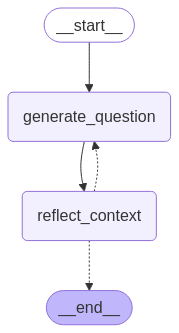

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print 
    pass

In [16]:
result = graph.invoke({"messages":["tongurso"]})
print(result)

{"question":"¿Cuál es la capital de Francia?","correctAnswer":"París","incorrectAnswers":["Páris","Londres","Berlín"]}
False
La respuesta correcta es 'París', que es efectivamente la capital de Francia.
{"question":"¿Cuál es la capital de Francia?","correctAnswer":"París","incorrectAnswers":["Páris","Londres","Berlín"]}
{'messages': [HumanMessage(content='tongurso', additional_kwargs={}, response_metadata={}, id='021b0377-dc82-475d-8d98-19333e6148e8')], 'loop_needed': False, 'content': '{"question":"¿Cuál es la capital de Francia?","correctAnswer":"París","incorrectAnswers":["Páris","Londres","Berlín"]}', 'updated_content': '{"question":"¿Cuál es la capital de Francia?","correctAnswer":"París","incorrectAnswers":["Páris","Londres","Berlín"]}'}


In [10]:
content_dict = json.loads(result.get("content", "{}"))  # Convert JSON string to dictionary
print(content_dict)

{'question': '¿Cuál es el río más largo del mundo?', 'correctAnswer': 'Río Amazonas', 'incorrectAnswers': ['Río Nilo', 'Río Mississippi', 'Río Ebro']}
